In [8]:
from pyhive import hive
import pandas as pd

host = 'localhost'  
port = 10000
username = 'hive'
database = 'default'

conn = hive.Connection(host=host, port=port, username=username, database=database)
cursor = conn.cursor()

query = "SELECT * FROM house_prices_features LIMIT 10"
cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame(data, columns=[desc[0] for desc in cursor.description])

print(df)

cursor.close()
conn.close()


   house_prices_features.feature1  house_prices_features.feature2  \
0                       37.454012                        9.256646   
1                       95.071431                       27.095047   
2                       73.199394                       43.647292   
3                       59.865848                       36.611244   
4                       15.601864                       40.328057   
5                       15.599452                       32.939168   
6                        5.808361                       34.613828   
7                       86.617615                       42.459783   
8                       60.111501                       12.483400   
9                       70.807258                       24.471248   

   house_prices_features.price  
0                    78.460473  
1                   143.457007  
2                   171.629492  
3                   156.829068  
4                   147.592893  
5                   115.646273  
6        

In [9]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import pandas as pd

cassandra_host = 'localhost'  
cassandra_port = 9042
cassandra_username = 'cassandra'
cassandra_password = 'cassandra'
keyspace = 'house_prices'
table = 'feature_store'

auth_provider = PlainTextAuthProvider(username=cassandra_username, password=cassandra_password)
cluster = Cluster([cassandra_host], port=cassandra_port, auth_provider=auth_provider)
session = cluster.connect(keyspace)

query = f"SELECT * FROM {table}"
rows = session.execute(query)

data = [row for row in rows]

df = pd.DataFrame(data)

print(df)

cluster.shutdown()


      feature1   feature2       price
0    86.518078  28.634286  136.482128
1    78.990617  28.105430  160.927962
2    76.292648  16.219269  121.092708
3    47.247751  26.818132  131.587598
4    48.707775   9.037970  100.233477
..         ...        ...         ...
995  75.963281  29.110411  151.149320
996  91.773698  33.694689  177.607773
997  66.562386  45.324230  164.815187
998  84.371316  15.025427  120.752766
999  27.326413  48.868200  155.991318

[1000 rows x 3 columns]


# Save model to cassandra repository

In [3]:
import xgboost as xgb
import pandas as pd
import uuid
import datetime
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pyhive import hive

hive_host = 'localhost'  
hive_port = 10000  
hive_database = 'default'  
hive_table = 'house_prices_features'  

conn = hive.Connection(host=hive_host, port=hive_port, database=hive_database)
query = f"SELECT feature1, feature2, price FROM {hive_table}"
df = pd.read_sql(query, conn)

X = df[['feature1', 'feature2']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',  
    'eval_metric': 'rmse',  
    'max_depth': 6,  
    'eta': 0.1,  
    'subsample': 0.8,  
    'colsample_bytree': 0.8  
}

num_round = 100  
model = xgb.train(params, dtrain, num_round)

y_pred = model.predict(dtest)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

model_file_path = 'house_price_prediction.model'
model.save_model(model_file_path)

with open(model_file_path, 'rb') as f:
    model_blob = f.read()

cassandra_host = 'localhost'  
cassandra_port = 9042
cassandra_username = 'cassandra'
cassandra_password = 'cassandra'
keyspace = 'model_repo'
table = 'models'

auth_provider = PlainTextAuthProvider(username=cassandra_username, password=cassandra_password)
cluster = Cluster([cassandra_host], port=cassandra_port, auth_provider=auth_provider)
session = cluster.connect(keyspace)

model_id = uuid.uuid4()
model_name = 'house_price_prediction'
model_version = '1.0'
created_at = datetime.datetime.now()

query = f"""
INSERT INTO {table} (model_id, model_name, model_version, model_file, created_at)
VALUES (%s, %s, %s, %s, %s)
"""
session.execute(query, (model_id, model_name, model_version, model_blob, created_at))

cluster.shutdown()


/var/folders/11/tkmmqjg12f5fhqjwtz4hr5z80000gn/T/ipykernel_9954/2011414373.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


RMSE: 11.535566552792071


/Users/nguyennam/anaconda3/envs/sk/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/nguyennam/anaconda3/envs/sk/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:06:05] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


# Write predictions to Hive

In [11]:
import xgboost as xgb
import pandas as pd
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
from pyhive import hive
import uuid
from sklearn.metrics import mean_squared_error

cassandra_host = 'localhost'  
cassandra_port = 9042
cassandra_username = 'cassandra'
cassandra_password = 'cassandra'
keyspace = 'model_repo'
table = 'models'

hive_host = 'localhost'
hive_port = 10000
hive_username = 'hive'
hive_database = 'default'

auth_provider = PlainTextAuthProvider(username=cassandra_username, password=cassandra_password)
cluster = Cluster([cassandra_host], port=cassandra_port, auth_provider=auth_provider)
session = cluster.connect(keyspace)

model_id = uuid.UUID('14c372cb-2abd-446b-bc32-2a01300567bd')  
query = f"SELECT model_file FROM {table} WHERE model_id = %s"
row = session.execute(query, (model_id,)).one()

model_file_path = 'loaded_house_price_prediction.model'
with open(model_file_path, 'wb') as f:
    f.write(row.model_file)

loaded_model = xgb.Booster()
loaded_model.load_model(model_file_path)

feature_store_query = "SELECT feature1, feature2, price FROM house_prices.feature_store LIMIT 1000"
rows = session.execute(feature_store_query)

data = [(row.feature1, row.feature2, row.price) for row in rows]
df = pd.DataFrame(data, columns=['feature1', 'feature2', 'price'])

X = df[['feature1', 'feature2']]
y = df['price']

dtest = xgb.DMatrix(X)

predictions = loaded_model.predict(dtest)
cluster.shutdown()

df['prediction'] = predictions
print(df)

conn = hive.Connection(host=hive_host, port=hive_port, username=hive_username, database=hive_database)
cursor = conn.cursor()

table_name = 'house_price_predictions'
create_table_query = f"""
CREATE TABLE IF NOT EXISTS {table_name} (
    feature1 DOUBLE,
    feature2 DOUBLE,
    price DOUBLE,
    prediction DOUBLE
) STORED AS PARQUET
"""
cursor.execute(create_table_query)

batch_size = 1000
insert_query = f"INSERT INTO TABLE {table_name} VALUES "
values = []

for i, row in df.iterrows():
    values.append(f"({row['feature1']}, {row['feature2']}, {row['price']}, {row['prediction']})")
    if (i + 1) % batch_size == 0 or i == len(df) - 1:
        cursor.execute(insert_query + ', '.join(values))
        values = []

cursor.close()
conn.close()


      feature1   feature2       price  prediction
0    86.518078  28.634286  136.482128  148.126434
1    78.990617  28.105430  160.927962  145.058273
2    76.292648  16.219269  121.092708  118.941231
3    47.247751  26.818132  131.587598  129.768082
4    48.707775   9.037970  100.233477  102.563858
..         ...        ...         ...         ...
995  75.963281  29.110411  151.149320  151.166763
996  91.773698  33.694689  177.607773  161.304520
997  66.562386  45.324230  164.815187  168.299072
998  84.371316  15.025427  120.752766  117.979927
999  27.326413  48.868200  155.991318  168.685059

[1000 rows x 4 columns]


# Evaluate

/var/folders/11/tkmmqjg12f5fhqjwtz4hr5z80000gn/T/ipykernel_62012/2557974824.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Mean Squared Error (MSE): 92.46076694085556
R-squared (R²): 0.9125958756051458


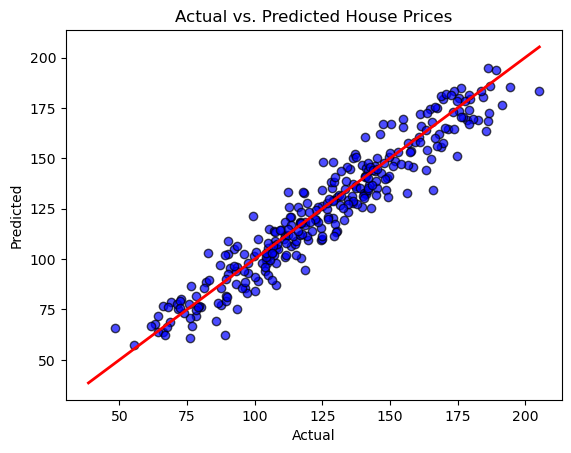

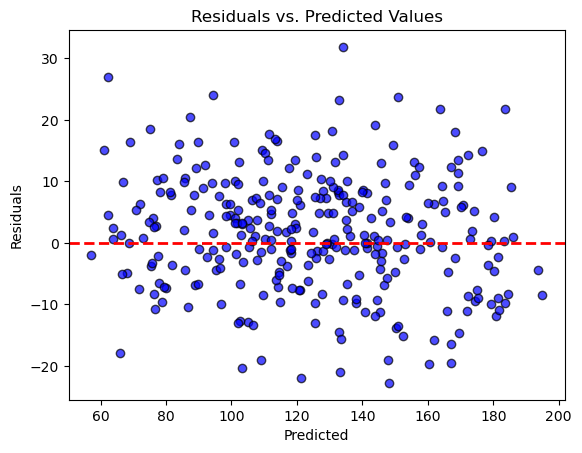

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from pyhive import hive

# Read data from Hive using Pandas (simulating the DataFrame we would get)
hive_host = 'localhost'
hive_port = 10000
hive_username = 'hive'
hive_database = 'default'

conn = hive.Connection(host=hive_host, port=hive_port, username=hive_username, database=hive_database)
query = "SELECT feature1, feature2, price, prediction FROM house_price_predictions"
df = pd.read_sql(query, conn)
conn.close()

# Prepare features and labels for model evaluation
X = df[['feature1', 'feature2']]
y = df['price']

# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

# Train linear regression model on training data
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions on test data
y_pred = lr.predict(X_test)

# Evaluate model using regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

# Plot actual vs. predicted values
plt.figure()
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted House Prices')
plt.show()

# Calculate residuals and plot residuals vs. predicted values
residuals = y_test - y_pred

plt.figure()
plt.scatter(y_pred, residuals, color='blue', edgecolors='k', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()


In [10]:
from pyhive import hive

hive_host = 'localhost'
hive_port = 10000
hive_username = 'hive'
hive_database = 'default'

conn = hive.Connection(host=hive_host, port=hive_port, username=hive_username, database=hive_database)
cursor = conn.cursor()

table_name = 'house_price_predictions'

truncate_query = f"TRUNCATE TABLE {table_name}"
cursor.execute(truncate_query)

select_query = f"SELECT * FROM {table_name} LIMIT 10"
cursor.execute(select_query)
rows = cursor.fetchall()
if len(rows) == 0:
    print(f"All data from the table '{table_name}' has been deleted.")
else:
    print(f"The table '{table_name}' still contains data.")

cursor.close()
conn.close()


All data from the table 'house_price_predictions' has been deleted.
